# Analysing Data with SciKit-Learn

In this notebook we import two data basis about MTG cards (MTG JSON, Gabriel Pierobon (see [here](https://towardsdatascience.com/artificial-intelligence-in-magic-the-gathering-4367e88aee11))) and merge them such that we have enough attributes (dimensions) to characterize cards. We study them by similarity to a given cards and cluster all cards to see typical magic cards (cluster centers). 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import nan
from PIL import Image
import requests
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

In [2]:
#Importing the Data
columns = pd.read_csv('../data/mtg_cards_data/datasets_vow_20211220_FULL.csv', nrows=0).columns
columns_with_obj_dtype = ['name','oracle_text','set','edhrec_rank','cmc_grp','usd','eur','tix',
               'normal_image','normal_image_1','normal_image_2','multiclass_colrs','multiclass_rarty',
               'multiclass_binusd','multiclass_bineur','multiclass_bintix']
dtype = {col: ('int8' if col not in columns_with_obj_dtype else 'object') for col in columns}

db1_cards = pd.read_csv('../data/mtg_cards_data/datasets_vow_20211220_FULL.csv', dtype=dtype)

columns = ['id','name','text','manaCost','manaValue','colorIdentity','colors','convertedManaCost','type','types','loyalty','power','toughness','keywords',
    'edhrecRank','life','defense','scryfallId','scryfallIllustrationId','scryfallOracleId','relatedCards']

dtype = {'id': 'int64','name': str,'text': str,'manaCost': str,'manaValue': float,'colorIdentity': str,'colors': str,
        'convertedManaCost': float,'type': str,'types': str,'loyalty': 'object','power': 'object','toughness': 'object',
        'keywords': str,'edhrecRank': 'object','life': 'object','defense': 'object','scryfallId': str,'scryfallIllustrationId': str,
        'scryfallOracleId': str,'relatedCards': str }

db2_cards = pd.read_csv('../data/mtg_cards_data/AllPrintingsCSVFiles/cards.csv',usecols = columns, dtype = dtype)

In [3]:
# Adding selected attributes of a preprocessed db 

attr_cat = 'counterspell,manarock,manadork,removal,wrath,ramp,tutor,cardraw,burn,discard,enters_bf,die_trigger,attack_trigger,pseudo_ramp,static_ramp,creature_tokens,extra_turn,plus1_counters,graveyard_hate,free_spells,bounce_spell,sac_outlet,sac_payoff,cant_counter,costx_more,costx_moreactivate,costx_less,costx_lessacitivate,whenever_opp,returnfrom_gy,reanimation,castfrom_gy,lord,upkeep_trigger,endstep_trigger,landfall,combat_trigger,life_gain,treasure_tokens,protection,cost_reduction,mana_multipliers,card_selection,whenever_cast,gain_control,unblockeable,difficult_block,create_copy,milling,trigger_multiplier,untapper,static_effects,damage_multipliers,variable_pt,agressive,doublers,blinker,graveyard_tutor,play_toplibrary,life_lose,play_from_graveyard,infect,disenchant,venture,animator,wish,gy_synergies,looting_similar,cheatinto_play,pumped_foreach,ritual,no_maximum,wheel,extra_combat,ghostly_prison,land_destruction,win_game,lose_game,cant_lose'.split(',')
attr_spez = 'Adamant,Adapt,Addendum,Affinity,Afflict,Afterlife,Aftermath,Amass,Amplify,Annihilator,Ascend,Assemble,Assist,Aura Swap,Awaken,Banding,Basic landcycling,Battalion,Battle Cry,Bestow,Bloodrush,Bloodthirst,Boast,Bolster,Bushido,Buyback,Cascade,Champion,Changeling,Channel,Chroma,Cipher,Clash,Cleave,Cohort,Commander ninjutsu,Companion,Conjure,Conspire,Constellation,Converge,Convoke,Coven,Crew,Cumulative upkeep,Cycling,Dash,Daybound,Deathtouch,Defender,Delirium,Delve,Demonstrate,Detain,Dethrone,Devoid,Devour,Disturb,Domain,Double strike,Dredge,Echo,Embalm,Emerge,Eminence,Enchant,Enrage,Entwine,Epic,Equip,Escalate,Escape,Eternalize,Evoke,Evolve,Exalted,Exert,Exploit,Explore,Extort,Fabricate,Fading,Fateful hour,Fateseal,Fear,Ferocious,Fight,First strike,Flanking,Flash,Flashback,Flying,Forecast,Forestcycling,Forestwalk,Foretell,Formidable,Fortify,Fuse,Goad,Graft,Grandeur,Gravestorm,Haste,Haunt,Hellbent,Heroic,Hexproof,Hexproof from,Hidden agenda,Hideaway,Horsemanship,Imprint,Improvise,Indestructible,Infect,Ingest,Inspired,Intimidate,Investigate,Islandcycling,Islandwalk,Join forces,Jump-start,Kicker,Kinship,Landcycling,Landfall,Landwalk,Learn,Legendary landwalk,Level Up,Lieutenant,Lifelink,Living weapon,Madness,Magecraft,Manifest,Megamorph,Meld,Melee,Menace,Mentor,Metalcraft,Mill,Miracle,Modular,Monstrosity,Morbid,Morph,Mountaincycling,Mountainwalk,Multikicker,Mutate,Myriad,Nightbound,Ninjutsu,Nonbasic landwalk,Outlast,Overload,Pack tactics,Parley,Partner,Partner with,Persist,Plainscycling,Plainswalk,Populate,Proliferate,Protection,Provoke,Prowess,Prowl,Radiance,Raid,Rally,Rampage,Reach,Rebound,Recover,Reinforce,Renown,Replicate,Retrace,Revolt,Riot,Ripple,Scavenge,Scry,Seek,Shadow,Shroud,Skulk,Slivercycling,Soulbond,Soulshift,Spectacle,Spell mastery,Splice,Split second,Storm,Strive,Sunburst,Support,Surge,Surveil,Suspend,Swampcycling,Swampwalk,Sweep,Tempting offer,Threshold,Totem armor,Training,Trample,Transfigure,Transform,Transmute,Tribute,Typecycling,Undaunted,Undergrowth,Undying,Unearth,Unleash,Vanishing,Vigilance,Ward,Will of the council,Wither,Wizardcycling'.split(',')
attr_color = 'colors_B,colors_BG,colors_BGR,colors_BGRU,colors_BGRUW,colors_BGRW,colors_BGU,colors_BGUW,colors_BGW,colors_BR,colors_BRU,colors_BRUW,colors_BRW,colors_BU,colors_BUW,colors_BW,colors_Colorless,colors_G,colors_GR,colors_GRU,colors_GRUW,colors_GRW,colors_GU,colors_GUW,colors_GW,colors_R,colors_RU,colors_RUW,colors_RW,colors_U,colors_UW,colors_W'.split(',')
attr_ctype = ['Creature_type','Artifact_type','Instant_type','Sorcery_type','Enchantment_type']

db1_cards = db1_cards.groupby('name',as_index=False).first()
db2_cards = db2_cards.groupby('name',as_index=False).first()

cards = pd.merge(db1_cards[attr_cat + attr_spez + attr_color + attr_ctype + ['name']],db2_cards, how='left', on='name')

In [4]:
# attributes used for clustering cards

attr = attr_cat + attr_spez + attr_color + attr_ctype + ['manaValue','loyalty','power','toughness']

# for simplification eval. variable card stats
cards['loyalty'] = cards['loyalty'].apply(lambda x: eval(str(x).replace('X','5')) if x else x)
cards['power'] = cards['power'].apply(lambda x: eval(str(x).replace('*','5')) if x else x)
cards['toughness'] = cards['toughness'].apply(lambda x: eval(str(x).replace('*','5')) if x else x)

db = cards[attr]

In [5]:
db_creatures = db[db['toughness'].notna()].drop(columns='loyalty')
db_planeswalker = db[db['loyalty'].notna()].drop(columns=['power','toughness'])
db_spells = db[db['toughness'].isna()]
db_spells = db_spells[db_spells['loyalty'].isna()].fillna(0).drop(columns=['loyalty','power','toughness'])

In [6]:
# clustering cards of creature cards

ngh = NearestNeighbors(n_neighbors=5)
ngh.fit(db_creatures.to_numpy())

NearestNeighbors()

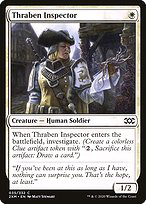

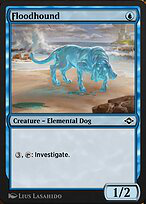

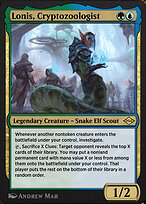

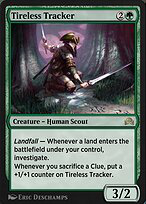

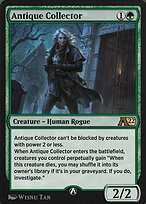

In [7]:
# Taking a random creature card with ngh

rdm_card_index = cards[cards.Creature_type == 1].index[np.random.randint(0,len(cards[cards.Creature_type == 1]))]
rdm_card = cards.loc[rdm_card_index]

dist, ind = ngh.kneighbors([db_creatures.loc[rdm_card_index,:].to_numpy()],n_neighbors=5)
for i in ind[0]: 
    x_i = cards.loc[db_creatures.index[i],:]
    im = Image.open(requests.get('https://api.scryfall.com/cards/' + x_i.scryfallId + '/?format=image&version=small', stream=True).raw)
    display(im)

In [8]:
pca = PCA(n_components = 10)
proj = pca.fit_transform(db_creatures.to_numpy())

typical Magic Creature Cards are: 


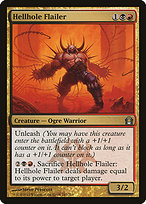

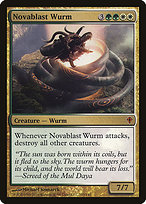

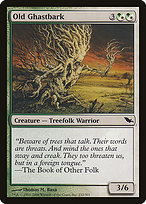

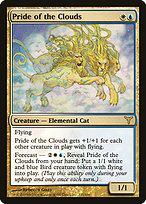

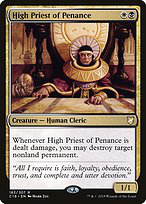

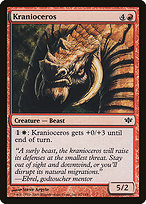

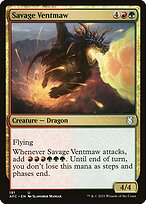

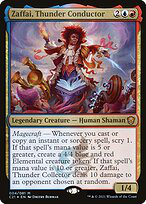

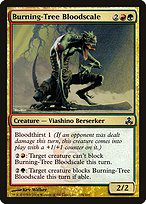

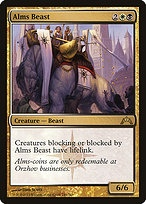

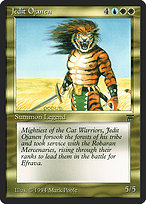

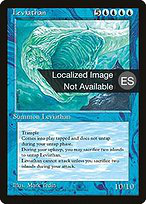

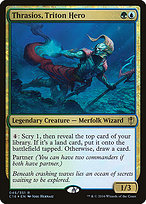

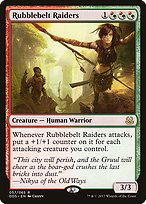

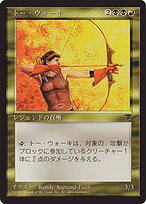

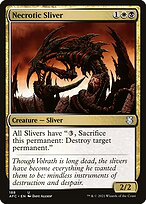

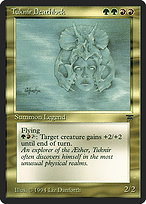

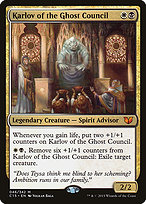

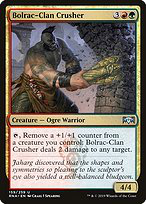

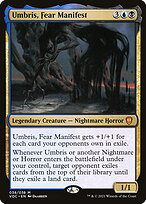

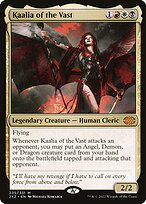

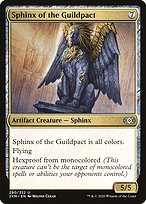

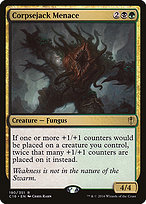

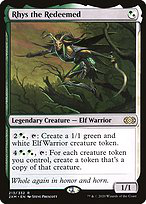

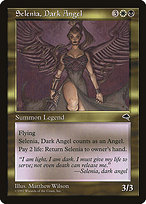

In [9]:
# typical MTG Creature Cards

kmeans= KMeans(n_clusters = 25, random_state = 0).fit(proj)
cluster_dist_space = kmeans.transform(proj)
df = pd.DataFrame(cluster_dist_space)

print('typical Magic Creature Cards are: ')

for i in range(25):
    df = df.sort_values(i,ascending=True)
    ind = df.index[0]
    x_i = cards.loc[db_creatures.index[ind],:]
    im = Image.open(requests.get('https://api.scryfall.com/cards/' + x_i.scryfallId + '/?format=image&version=small', stream=True).raw)
    display(im)